# Estrategia sistemática Pablo Patiño




In [2]:
# Estrategia sistemática Pablo Patiño


import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from yahoofinancials import YahooFinancials
import yahoo_fin.stock_info as si
import mplfinance as mpf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
import statistics
import matplotlib.pyplot as plt

In [3]:
# aquí pongo la fecha en la que voy a evaluar la estrategia
start= datetime.datetime(2021,1,1)
end= datetime.datetime(2021,2,28)

In [4]:
dow_jones=si.tickers_dow()

In [5]:
# descargo los precios determinados de yahoo finance
Data= yf.download(dow_jones, start=start, end=end)
sandp500=yf.download('SPY', start=start, end=end)

[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
prices= Data['Adj Close']# selecciono los precios de cierre ajustados para hacer el análisis
syp500=sandp500["Adj Close"]


In [7]:
# aca hago el pronóstico a 3 días con el modelo SES. Por definición estos pronósticos son iguales, así que da igual si se pronóstica un solo día
# como mencioné, hay una cantidad arbitraria de días de aprendizaje, por lo tanto, la señal es 0. Se repite en las otras
# 3 señales
def SES(base,ce=0.01):
    ses=pd.DataFrame(index=base.index,columns=base.columns)
    ses.columns=["s"]
    sbase=base.copy(deep=True)
    sbase.reset_index(drop=True, inplace=True)
    for i in range(0,len(base)):
        if i<=10:
            ses.iloc[i]=0
        else:
            aux=sbase.loc[:i]
            mod=SimpleExpSmoothing(aux).fit().forecast(3)
            ses.iloc[i]=np.mean(mod)
    return ses
        

In [8]:
# promedio pronóstico a 3 días de Holt. La función optimiza las parametros automaticamente si uno no los pone (mi caso)
def holt(base):
    sus=pd.DataFrame(index=base.index,columns=base.columns)
    sus.columns=["h"]
#sus.rename(columns={"AAPL":"holt"})
    sbase=base.copy(deep=True)
    sbase.reset_index(drop=True, inplace=True)
    for i in range(0,len(base)):
        if i<=10:
            sus.iloc[i]=0
        else:
            aux=sbase.loc[:i]
            mod=ExponentialSmoothing(aux,trend="add",damped_trend=False,seasonal=None).fit().forecast(3)
            sus.iloc[i]=np.mean(mod)
        
    return sus

In [9]:
# promedio pronóstico a 3 días de Holt Damped. La función optimiza las parametros automaticamente si uno no los pone (mi caso)
def holtd(base):
    sas=pd.DataFrame(index=base.index,columns=base.columns)
    sas.columns=["hd"]
    sbase=base.copy(deep=True)
    sbase.reset_index(drop=True, inplace=True)
    for i in range(0,len(base)):
        if i<=10:
            sas.iloc[i]=0
        else:
            aux=sbase.loc[:i]
            mod=ExponentialSmoothing(aux,trend="add",damped_trend=True,seasonal=None).fit().forecast(3)
            sas.iloc[i]=np.mean(mod)
    return sas
    

In [10]:
# promedio pronóstico a 3 días.Normalmente en un Arima toca específicar 3 hiperparámetros, pero esta función que estoy 
# usando acá permite que estos se optimicen automaticamente, como suele suceder en R. La desventaja es que toma bastante
# tiempo, por lo que la demostración no se hará en muchos valores, pues tardaría horas en realizar los pronósrticos.
def arima(base):
    sos=pd.DataFrame(index=base.index,columns=base.columns)
    sos.columns=["arm"]
    sbase=base.copy(deep=True)
    sbase.reset_index(drop=True, inplace=True)
    for i in range(0,len(base)):
        if i<=10:
            sos.iloc[i]=0
        else:
            aux=sbase.loc[:i]
            mod=auto_arima(aux,supress_warnings=True,stepwise=True).fit(aux).predict(3)
            sos.iloc[i]=np.mean(mod)
    return sos

In [11]:
# creación de la variable binaria. 1 si se cumple la señal de entrada de SES  y 0 en caso contrario. Por default el porcentaje
# de incremento es 1%, pero puede modificarse.
def smooth(base,ce=0.01):
    mat1=pd.DataFrame(index=base.index,columns=base.columns)
    mat1.columns=["señal_ses"]
    aja=SES(base)
    for i in range(len(base)):
        if i<=10:
            mat1.iloc[i]=0
        else:
            if np.array(aja.iloc[i])>((1+ce)*np.mean(np.array(base.iloc[i-2:i+1]))):
                mat1.iloc[i]=1
            else:
                mat1.iloc[i]=0
    return mat1

In [12]:
# creación de la variable binaria. 1 si se cumple la señal de entrada de Holt  y 0 en caso contrario. Por default el porcentaje
# de incremento es 1%, pero puede modificarse.
def ht(base,ce=0.01):
    mat2=pd.DataFrame(index=base.index,columns=base.columns)
    mat2.columns=["señal_holt"]
    eje=holt(base)
    for i in range(len(base)):
        if i<=10:
            mat2.iloc[i]=0
        else:
            if np.array(eje.iloc[i])>((1+ce)*np.mean(np.array(base.iloc[i-2:i+1]))):
                mat2.iloc[i]=1
            else:
                mat2.iloc[i]=0
    return mat2

In [13]:
# creación de la variable binaria. 1 si se cumple la señal de entrada de Holt Damped  y 0 en caso contrario. Por default el porcentaje
# de incremento es 1%, pero puede modificarse.
def htd(base,ce=0.01):
    mat3=pd.DataFrame(index=base.index,columns=base.columns)
    mat3.columns=["señal_holt_damped"]
    iji=holtd(base)
    for i in range(len(base)):
        if i<=10:
            mat3.iloc[i]=0
        else:
            if np.array(iji.iloc[i])>((1+ce)*np.mean(np.array(base.iloc[i-2:i+1]))):
                mat3.iloc[i]=1
            else:
                mat3.iloc[i]=0
    return mat3

In [14]:
# creación de la variable binaria. 1 si se cumple la señal de entrada de Arima  y 0 en caso contrario. Por default el porcentaje
# de incremento es 1%, pero puede modificarse.
def ari(base,ce=0.01):
    mat4=pd.DataFrame(index=base.index,columns=base.columns)
    mat4.columns=["señal_arima"]
    ojo=arima(base)
    for i in range(len(base)):
        if i<=10:
            mat4.iloc[i]=0
        else:
            if np.array(ojo.iloc[i])>((1+ce)*np.mean(np.array(base.iloc[i-2:i+1]))):
                mat4.iloc[i]=1
            else:
                mat4.iloc[i]=0
    return mat4

In [15]:
# suma de las señales cada día. 
def señal_total(base):
    bas=pd.DataFrame(index=base.index,columns=base.columns)
    bas.columns=["tot_señal"]
    se=smooth(base)
    hl=ht(base)
    hld=htd(base)
    ar=ari(base)
    for i in range(len(base)):
        if sum([np.array(se.iloc[i]),np.array(hl.iloc[i]),np.array(hld.iloc[i]),np.array(ar.iloc[i])])<=2:
            bas.iloc[i]=0
        if sum([np.array(se.iloc[i]),np.array(hl.iloc[i]),np.array(hld.iloc[i]),np.array(ar.iloc[i])])==3:
            bas.iloc[i]=80
        if sum([np.array(se.iloc[i]),np.array(hl.iloc[i]),np.array(hld.iloc[i]),np.array(ar.iloc[i])])==4:
            bas.iloc[i]=100
    se_t=pd.concat([se,hl,hld,ar,bas],axis=1)
        
    return se_t
            
    

In [16]:
def cantidad_comprar(base):
    iyi=pd.DataFrame(index=base.index,columns=base.columns)
    iyi.columns=["cantidad_compra"]
    st=señal_total(base)
    for i in range(len(base)):
        if i<=10:
            iyi.iloc[i]=0
        else:
            if np.array(st["tot_señal"].iloc[i-1])==0:
                iyi.iloc[i]=0
            if np.array(st["tot_señal"].iloc[i-1])!=0:
                iyi.iloc[i]=st["tot_señal"].iloc[i-1]
    kasu=pd.concat([st,iyi],axis=1)
    return kasu


In [17]:
def propiedad(base):
    uyu=pd.DataFrame(index=base.index,columns=base.columns)
    uyu.columns=["inventario"]
    fa=cantidad_comprar(base)
    for i in range(len(base)):
        if i==0:
            uyu.iloc[i]=0
        else:
            if fa["tot_señal"].iloc[i-1]==0:
                uyu.iloc[i]=0
            else:
                uyu.iloc[i]=uyu.iloc[i-1]+fa["cantidad_compra"].iloc[i]
    qqq=pd.concat([fa,uyu],axis=1)
    return qqq
    
    

In [18]:
def cantidad_vender(base):
    inte=pd.DataFrame(index=base.index,columns=base.columns)
    inte.columns=["venta"]
    wa=propiedad(base)
    for i in range(len(base)):
        if i==0:
            inte.iloc[i]=0
        else:
            if wa["inventario"].iloc[i]==0:
                inte.iloc[i]=wa["inventario"].iloc[i-1]
            else:
                inte.iloc[i]=0
    tt=pd.concat([wa,inte],axis=1)
    return tt

In [19]:
def efectivo(base,com_c=1/1000,com_v=1/1000,dinero=100000):
    efe=pd.DataFrame(index=base.index,columns=base.columns)
    efe.columns=["dinero"]
    total=cantidad_vender(base)
    for i in range(len(base)):
        if i==0:
            efe.iloc[i]=dinero
        else:
            efe.iloc[i]=(np.array(efe.iloc[i-1]))-((1+com_c)*np.array(base.iloc[i])*np.array(total["cantidad_compra"].iloc[i]))+((1-com_v)*np.array(base.iloc[i])*np.array(total["venta"].iloc[i]))
    gea=pd.concat([base,total,efe],axis=1)
    return gea
    

In [20]:
def valor_inventario(base):
    vi=pd.DataFrame(index=base.index,columns=base.columns)
    vi.columns=["valor_acciones"]
    ñam=efectivo(base)
    for i in range(len(base)):
        vi.iloc[i]=np.array(base.iloc[i])*np.array(ñam["inventario"].iloc[i])
    ha=pd.concat([ñam,vi],axis=1)
    return ha


In [21]:
def portafolio(base):
    port=pd.DataFrame(index=base.index,columns=base.columns)
    port.columns=["valor portafolio"]
    xaka=valor_inventario(base)
    for i in range(len(base)):
        port.iloc[i]=np.array(xaka["dinero"].iloc[i])+np.array(xaka["valor_acciones"].iloc[i])
    vy=pd.concat([xaka,port],axis=1)
    return vy

In [22]:
def total(datos,tickers):
    a=[]
    b=pd.DataFrame(a,index=tickers)
    mun=pd.DataFrame(index=datos.index)
    mon=pd.DataFrame(index=datos.index,columns=["PORTAFOLIO"])
    for i in range(len(tickers)):
        p=portafolio(pd.DataFrame(datos.iloc[:,i]))
        cafir=p["valor portafolio"]
        mun=pd.concat([mun,cafir],axis=1)
    for i in range(len(datos)):
        mon.iloc[i]=sum(mun.iloc[i,:])
    return mon
        
        

In [23]:
def peak(base):
    pk=pd.DataFrame(index=base.index,columns=["peak"])
    for i in range(len(base)):
        if i==0:
            pk.iloc[i]=base.iloc[i]
        else:
            if np.array(base.iloc[i])>np.array(pk.iloc[i-1]):
                pk.iloc[i]=base.iloc[i]
            else:
                pk.iloc[i]=pk.iloc[i-1]
    return pk

In [24]:
def SYP500(base,cc=1/1000):
    fal=pd.DataFrame(index=base.index,columns=["p_s&p500"])
    for i in range(len(base)):
        if i<=10:
            fal.iloc[i]=3000000
        else:
            ci=3000000/(np.array(base.iloc[11])*(1+cc))
            fal.iloc[i]=ci*base.iloc[i]
    
    rsyp=float(100*(np.array(fal.iloc[-1])-np.array(fal.iloc[0]))/np.array(fal.iloc[0]))
    reto=pd.DataFrame(index=base.index,columns=["returns"])
    for i in range(len(base)):
        if i==0:
            reto.iloc[i]=0
        else:
            reto.iloc[i]=(np.array(fal.iloc[i])-np.array(fal.iloc[i-1]))/(np.array(fal.iloc[i-1]))
    r500=100*statistics.mean(reto["returns"].iloc[1:])
    v500=100*statistics.stdev(reto["returns"].iloc[1:])
    peak500=peak(pd.DataFrame(fal))
    draw500=pd.DataFrame(index=fal.index,columns=["drawdown500"])
    for i in range(len(draw500)):
        if i==0:
            draw500.iloc[i]=0
        else:
            draw500.iloc[i]=100*(np.array(peak500.iloc[i])-np.array(fal.iloc[i]))/np.array(peak500.iloc[i])
    maxdr500=float(np.array(draw500.max(axis=0)))
    cr500=rsyp/maxdr500
    print("el max drawdown del s&p500 es:",maxdr500,"%")
    print("la rentabilidad diaria promedio del s&p500 es:",r500,"%")
    print("la rentabilidad del s&p500 en el periodo analizado fue:",rsyp,"%")
    print("la volatilidad de los retornos de la estrategia es:",v500,"%")
    print("como los rendimientos no están anualizados, una aproximación al calmar ratio es:",cr500)
    
    return fal
    

In [25]:
def com_pablo_500(datos,base500,tickers,cc=1/1000):
    porta=total(datos,tickers)
    fal=pd.DataFrame(index=base500.index,columns=["p_s&p500"])
    for i in range(len(base500)):
        if i<=10:
            fal.iloc[i]=3000000
        else:
            ci=3000000/(np.array(base500.iloc[11])*(1+cc))
            fal.iloc[i]=ci*base500.iloc[i]
    
    rsyp=float(100*(np.array(fal.iloc[-1])-np.array(fal.iloc[0]))/np.array(fal.iloc[0]))
    reto=pd.DataFrame(index=base500.index,columns=["returns"])
    for i in range(len(base500)):
        if i==0:
            reto.iloc[i]=0
        else:
            reto.iloc[i]=(np.array(fal.iloc[i])-np.array(fal.iloc[i-1]))/(np.array(fal.iloc[i-1]))
    r500=100*statistics.mean(reto["returns"].iloc[1:])
    v500=100*statistics.stdev(reto["returns"].iloc[1:])
    peak500=peak(pd.DataFrame(fal))
    draw500=pd.DataFrame(index=fal.index,columns=["drawdown500"])
    for i in range(len(draw500)):
        if i==0:
            draw500.iloc[i]=0
        else:
            draw500.iloc[i]=100*(np.array(peak500.iloc[i])-np.array(fal.iloc[i]))/np.array(peak500.iloc[i])
    maxdr500=float(np.array(draw500.max(axis=0)))
    cr500=rsyp/maxdr500
    print("el max drawdown del s&p500 es:",maxdr500,"%")
    print("la rentabilidad diaria promedio del s&p500 es:",r500,"%")
    print("la rentabilidad del s&p500 en el periodo analizado fue:",rsyp,"%")
    print("la volatilidad de los retornos del s&p500 es:",v500,"%")
    print("como los rendimientos no están anualizados, una aproximación al calmar ratio es:",cr500)
    zam=pd.DataFrame(index=porta.index,columns=["retornos"])
    for i in range(len(zam)):
        if i==0:
            zam.iloc[i]=0
        else:
            zam.iloc[i]=(np.array(porta.iloc[i])-np.array(porta.iloc[i-1]))/(np.array(porta.iloc[i-1]))
    pqs=pd.concat([porta,zam],axis=1)
    pea=peak(pd.DataFrame(porta))
    draw=pd.DataFrame(index=porta.index,columns=["drawdown"])
    for i in range(len(draw)):
        if i==0:
            draw.iloc[i]=0
        else:
            draw.iloc[i]=100*(np.array(pea.iloc[i])-np.array(porta.iloc[i]))/np.array(pea.iloc[i])
    maxdr=float(np.array(draw.max(axis=0)))
    hh=pd.concat([pqs,pea,draw],axis=1)
    ren=float(100*(np.array(porta.iloc[-1])-np.array(porta.iloc[0]))/(np.array(porta.iloc[0])))
    rentp=float(sum(np.array(zam))/(len(zam)-1)*100)
    vol=100*statistics.stdev(zam["retornos"].iloc[1:])
    cr=ren/maxdr
    
    print("el max drawdown del portafolio es:",maxdr,"%")
    print("la rentabilidad diaria promedio del portafolio es:",rentp,"%")
    print("la rentabilidad del portafolio en el periodo analizado fue:",ren,"%")
    print("la volatilidad de los retornos de la estrategia es:",vol,"%")
    print("como no hay una temporalidad fija, no es correcto cslcular el sharp ratio,pues varía la tasa libre de riesgo, sin embargo, es negativo")
    print("como los rendimientos no están anualizados, una aproximación al calmar ratio es:",cr)
   
    eureca=pd.concat([porta,fal],axis=1)
    
    fig, ax = plt.subplots()
    ax =eureca.plot(ax=ax)



    
    return eureca


el max drawdown del s&p500 es: 3.7253822315558525 %
la rentabilidad diaria promedio del s&p500 es: -0.02410685956765283 %
la rentabilidad del s&p500 en el periodo analizado fue: -1.0185082911535632 %
la volatilidad de los retornos del s&p500 es: 0.8523904172371767 %
como los rendimientos no están anualizados, una aproximación al calmar ratio es: -0.27339699065676754
el max drawdown del portafolio es: 0.5071168299153602 %
la rentabilidad diaria promedio del portafolio es: -0.013718876781401669 %
la rentabilidad del portafolio en el periodo analizado fue: -0.5071168299153602 %
la volatilidad de los retornos de la estrategia es: 0.06553029627449344 %
como no hay una temporalidad fija, no es correcto cslcular el sharp ratio,pues varía la tasa libre de riesgo, sin embargo, es negativo
como los rendimientos no están anualizados, una aproximación al calmar ratio es: -1.0


,PORTAFOLIO,p_s&p500
Date,,
2021-01-04,3000000.0,3000000
2021-01-05,3000000.0,3000000
2021-01-06,3000000.0,3000000
2021-01-07,3000000.0,3000000
2021-01-08,3000000.0,3000000
2021-01-11,3000000.0,3000000
2021-01-12,3000000.0,3000000
2021-01-13,3000000.0,3000000
2021-01-14,3000000.0,3000000


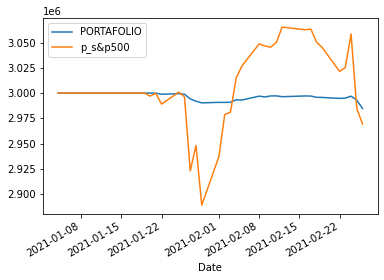

In [26]:
com_pablo_500(prices,syp500,dow_jones)

Para aclarar, en mi portafolio asumí que para cada acción hay un presupuesto inicial de 100000 dólares, y como en el dow jones hay 30 acciones, mi portafolio tiene inicialmente 3 millones de dólares en efectivo. Es posible endeudarse para comprar acciones, y por simplicidad, la deuda no paga intereses. Para compararlo con el rendimiento del s&p500, asumí que en el día 12 invertí 3 millones de dólares en el índice. La posición nunca la vendo, y tengo en cuesta los costos transaccionales (10 pb) para la primera compra. Como el auto arima se demora tanto, compare mi estrategia con el s&p500 en los 2 primeros meses del año.